## Data Loading

In [42]:
# !pip install polars
# !pip install umap-learn

Исходный файл с embedding-векторами содержит очень большое количество данных — порядка 16 ГБ на диске.
Важно понимать, что размер файла ≠ размер в оперативной памяти.
При загрузке векторных данных в RAM их объём обычно увеличивается, поскольку:

* данные раскодируются из колоннарного формата Parquet,
* создаются внутренние структуры DataFrame,
* происходит выравнивание/оптимизация типов.

В итоге фактическое потребление памяти может быть в 1.5–3 раза выше, чем вес файла.

Чтобы работать с данными без полной загрузки всего массива в память, используется библиотека Polars. Она поддерживает ленивое выполнение, построчное сканирование Parquet-файлов, выборку только нужного числа строк и при этом обеспечивает высокую скорость и низкое потребление памяти благодаря реализации на Rust. Всё это позволяет эффективно обрабатывать большие датасеты, не превышая ограничений оперативной памяти.

In [7]:
import polars as pl

def estimate_parquet_ram_usage(path: str, sample_rows: int = 10_000):
    print(f"\n📁 Файл: {path}")
    print(f"📊 Сэмпл строк: {sample_rows:,}")

    # читаем sample
    df_sample = pl.read_parquet(path, n_rows=sample_rows)
    size_sample = df_sample.estimated_size()
    print(f"🔹 Размер sample: {size_sample/1024**2:.2f} MB")

    # ленивое сканирование для подсчёта строк
    lf = pl.scan_parquet(path)
    total_rows = lf.select(pl.len()).collect().item()
    print(f"🔹 Всего строк в файле: {total_rows:,}")

    # оценка общего размера
    estimated_total_bytes = size_sample * (total_rows / sample_rows)
    estimated_total_gb = estimated_total_bytes / 1024**3

    print(f"\n📐 Примерная оценка объёма данных в памяти: {estimated_total_gb:.2f} GB")



# пример использования
estimate_parquet_ram_usage("../data/embeddings.parquet")



📁 Файл: ../data/embeddings.parquet
📊 Сэмпл строк: 10,000
🔹 Размер sample: 117.38 MB
🔹 Всего строк в файле: 7,721,749

📐 Примерная оценка объёма данных в памяти: 88.51 GB


В данном проекте используется только подмножество данных — датасет на 50 миллионов записей.
Поэтому на первой итерации мы извлекаем только нужный сегмент, не работая со всем большим embedding-файлом.

In [8]:
import pandas as pd


multi_event_50M = pd.read_parquet("../data/multi_event.parquet", engine="fastparquet", columns=["item_id"])
embed_5b = pl.scan_parquet("../data/embeddings.parquet")

total_embeddings_rows = embed_5b.select(pl.len()).collect().item()  # Предполагается, что они все уникальные :)
unique_item_ids_50M = multi_event_50M["item_id"].nunique()

ratio = (unique_item_ids_50M / total_embeddings_rows) * 100


print(f"Используемое количество данные в 50M: {round(ratio, 2)}%")


Используемое количество данные в 50M: 12.1%


Так как мы используем лишь 12% исходного датасета, мы сразу отбираем только нужные записи и сохраняем их в отдельный файл, уменьшая объём данных и ускоряя последующую обработку.

In [9]:
import time
start = time.time()

unique_item_50M = multi_event_50M["item_id"].unique().tolist()

(
    embed_5b
    .filter(pl.col("item_id").is_in(unique_item_50M))
    .sink_parquet("filtered_embeddings.parquet")
)

end = time.time()
duration = end - start

print(f"⏱ Фильтрация и сохранение завершены за {duration:.2f} сек ({duration/60:.2f} мин).")

⏱ Фильтрация и сохранение завершены за 212.92 сек (3.55 мин).


## Data Cleaning

### Фильтрация дублей по embeddings

Проверим нет ли дубликатов embeddings

In [25]:
embed_df = pl.scan_parquet("filtered_embeddings.parquet")

dupes = (
    embed_df
    .with_columns(pl.col("embed").hash().alias("h"))
    .group_by("h")
    .agg([
        pl.len().alias("dup_count"),
        pl.col("item_id").alias("item_ids"),   
    ])
    .filter(pl.col("dup_count") > 1)
    .collect(engine="streaming") 
)

dupes



h,dup_count,item_ids
u64,u32,list[u32]
2833615793745376201,2,"[1147108, 4096388]"
6853723085163307689,2,"[4340639, 5110655]"
8075462634677102445,2,"[2260752, 3818593]"
12602122677565559315,2,"[4235422, 7125134]"
11267668079004336834,2,"[1694243, 8496261]"
…,…,…
3921963202574077658,2,"[1393313, 5978692]"
7851075014094279059,2,"[1665619, 6441249]"
10944765622232567853,2,"[6381614, 7764951]"


В данных присутствуют дубликаты — вероятно, одна и та же песня была загружена под разными item_id. Процент повторов составляет около 1.7%: показатель небольшой, но всё же достаточно значимый, чтобы их исключить.

Чтобы корректно обработать эту ситуацию, создадим JSON-карту соответствий, где для каждой группы дублей будет выбран один “эталонный” item_id. Остальные идентификаторы будут сопоставлены с ним как эквивалентные.

In [29]:
per_of_dup = sum(dupes["dup_count"])/ unique_item_ids_50M *100
print(f"Процент дубликатов {round(per_of_dup, 2)}%")

Процент дубликатов 1.71%


In [32]:
import json


# Все item_id в датасете
all_items = set(unique_item_50M)

mapping = {}

# 1. Обрабатываем дубли: каждый id → canonical
for group in dupes["item_ids"]:
    canonical_id = group[0]
    for item_id in group:
        mapping[item_id] = canonical_id

# 2. Добавляем недостающие id как identity mapping
for item_id in all_items:
    if item_id not in mapping:
        mapping[item_id] = item_id

# Сохраняем в JSON
output_path = "item_id_mapping.json"
with open(output_path, "w", encoding="utf-8") as f:
    json.dump(mapping, f, ensure_ascii=False, indent=4)

print(f"✔ Mapping сохранён в '{output_path}'")
print(f"🔹 Всего item_id в датасете: {len(all_items):,}")
print(f"🔹 Записей в итоговом mapping: {len(mapping):,}")

✔ Mapping сохранён в 'item_id_mapping.json'
🔹 Всего item_id в датасете: 934,057
🔹 Записей в итоговом mapping: 934,057


### Фильтрация дублей по item_id

In [12]:
embed_df = pl.scan_parquet("filtered_embeddings.parquet")

dupes = (
    embed_df
    .with_columns(pl.col("embed").hash().alias("h"))
    .group_by("h")
    .agg([
        pl.len().alias("dup_count"),
        pl.col("item_id").alias("item_ids"),   
    ])
    .filter(pl.col("dup_count") > 1)
    .collect(engine="streaming") 
)

dupes

h,dup_count,item_ids
u64,u32,list[u32]
9079638452460116477,2,"[4757992, 6156435]"
5377353581306548589,2,"[4096864, 8195897]"
8894807848111532958,2,"[1241744, 7239896]"
5715412884990321596,4,"[1113757, 2131428, … 8617353]"
14560092848069229989,2,"[7622441, 9319657]"
…,…,…
16326518871983664726,2,"[2890165, 7575318]"
976088310256915929,2,"[1901030, 5514170]"
13246534090568757572,2,"[4650842, 5655792]"


Дублей по item_id не нашлось

### Удаление выбросов 

In [35]:
# пример использования
estimate_parquet_ram_usage("filtered_embeddings.parquet")


📁 Файл: filtered_embeddings.parquet
📊 Сэмпл строк: 10,000
🔹 Размер sample: 117.38 MB
🔹 Всего строк в файле: 847,921

📐 Примерная оценка объёма данных в памяти: 9.72 GB


In [2]:
import polars as pl

import numpy as np
from umap.umap_ import UMAP
# from sklearn.utils import gen_batches

# параметры
batch_size = 50000

# создаём модель в инкрементальном режиме
um = UMAP(
    n_neighbors=15,
    n_components=2,
    low_memory=True,          # Важно!
    verbose=True
)

# # fit по частям
# for batch_idx in gen_batches(n_samples, batch_size):

#     n_rows=sample_rows
batch = pl.read_parquet("filtered_embeddings.parquet", n_rows=batch_size)  


In [3]:
X = batch["normalized_embed"].to_list()
X = np.array(X, dtype="float32")

y = batch["item_id"].to_list()

In [8]:
from sklearn.decomposition import PCA

pca = PCA(n_components=50, random_state=42)
emb_pca = pca.fit_transform(X)

embedding = um.fit_transform(emb_pca)

UMAP( verbose=True)
Fri Nov 14 14:45:45 2025 Construct fuzzy simplicial set
Fri Nov 14 14:45:45 2025 Finding Nearest Neighbors
Fri Nov 14 14:45:45 2025 Building RP forest with 16 trees
Fri Nov 14 14:45:46 2025 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	Stopping threshold met -- exiting after 4 iterations
Fri Nov 14 14:45:47 2025 Finished Nearest Neighbor Search
Fri Nov 14 14:45:47 2025 Construct embedding


Epochs completed:   2%| ██                                                                                   5/200 [00:00]

	completed  0  /  200 epochs


Epochs completed:  14%| ████████████                                                                        29/200 [00:00]

	completed  20  /  200 epochs


Epochs completed:  24%| ████████████████████▎                                                               49/200 [00:01]

	completed  40  /  200 epochs


Epochs completed:  32%| ██████████████████████████▉                                                         65/200 [00:01]

	completed  60  /  200 epochs


Epochs completed:  43%| ███████████████████████████████████▋                                                86/200 [00:02]

	completed  80  /  200 epochs


Epochs completed:  52%| ██████████████████████████████████████████▋                                        104/200 [00:02]

	completed  100  /  200 epochs


Epochs completed:  64%| ████████████████████████████████████████████████████▉                              129/200 [00:03]

	completed  120  /  200 epochs


Epochs completed:  73%| ███████████████████████████████████████████████████████████▊                       146/200 [00:03]

	completed  140  /  200 epochs


Epochs completed:  84%| ████████████████████████████████████████████████████████████████████▍              167/200 [00:04]

	completed  160  /  200 epochs


Epochs completed:  94%| █████████████████████████████████████████████████████████████████████████████▍     189/200 [00:05]

	completed  180  /  200 epochs


Epochs completed: 100%| ██████████████████████████████████████████████████████████████████████████████████ 200/200 [00:05]

Fri Nov 14 14:46:03 2025 Finished embedding


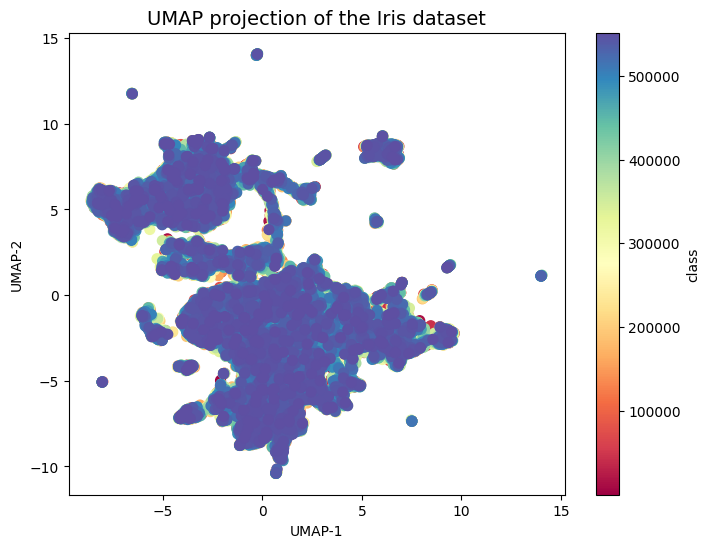

In [9]:
import matplotlib.pyplot as plt
# Отрисовка
plt.figure(figsize=(8, 6))
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=y,
    cmap="Spectral",
    s=50
)
plt.title("UMAP projection of the Iris dataset", fontsize=14)
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.colorbar(label="class")
plt.show()


UMAP показывает, 50 000 embedding-векторов не имеют ярко выраженной структуры.
Большинство точек лежат в одном плотном облаке, без заметных кластеров — значит:

* embedding-векторы слишком похожи друг на друга,
* кластеризация выражена слабо или отсутствует,
* возможны дубликаты или недостаточная нормализация.
